https://docs.gpytorch.ai/en/v1.13/examples/05_Deep_Gaussian_Processes/Deep_Gaussian_Processes.html
https://docs.gpytorch.ai/en/v1.13/examples/05_Deep_Gaussian_Processes/DGP_Multitask_Regression.html

In [1]:
%set_env CUDA_VISIBLE_DEVICES=0

import torch
import tqdm
import gpytorch
from gpytorch.means import ConstantMean, LinearMean
from gpytorch.kernels import RBFKernel, ScaleKernel
from gpytorch.variational import VariationalStrategy, CholeskyVariationalDistribution
from gpytorch.distributions import MultivariateNormal
from gpytorch.models import ApproximateGP, GP
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.likelihoods import GaussianLikelihood

env: CUDA_VISIBLE_DEVICES=0


In [2]:
from gpytorch.models.deep_gps import DeepGPLayer, DeepGP
from gpytorch.mlls import DeepApproximateMLL

In [3]:
import os
os.getcwd()

'/Users/chenya68/Documents/GitHub/BFO-other/deep-gp'

## Loan input dataset

In [37]:
ls_model = ['rf','simpleGP','multi-task-single-output','multi-task-multi-output','multi-task-multi-input-multi-output']
ls_x_scale = ['no-x-scale','x-minmax','x-stand','x-robust']
ls_y_scale = ['no-y-scale','y-minmax','y-stand','y-robust']
ls_cate_transform = ['none','label','ohe','LVGP','LMGP']
ls_remove_pred_outlier = [0,1]
ls_output_rank_option = [1,2]
ls_task_rank_option = [1,2,3,4,5,6,7]
ls_lik_rank_option = [0,1,2]
ls_split_option = ['mix','separate'] #mix: combine all tasks first then do train, test split (could stratify task?) #separate, do train-test-split first, then combine tasks
ls_stratify_task = ['not-stratify','stratify-x','stratify-y','stratify-xy']


model_option = 'deep-gp'
x_scale_option = 'x-minmax'
y_scale_option = 'y-minmax'
cate_transform_option = 'label'

#output_rank_option = 1 #if 0, no correlation between output
task_rank_option = 6#if 0, no correlation between tasks
lik_rank_option = 1
split_option = 'mix'
stratify_option = 'stratify-x'


model_label = model_option
x_scale_label = x_scale_option
y_scale_label = y_scale_option
cate_transform_label = 'cate_transform_'+cate_transform_option

if model_option == 'multi-task-single-output' or  model_option =='multi-task-multi-output':
        task_rank_label = 'task_rank_'+str(task_rank_option)
        lik_rank_label = 'lik_rank_'+str(lik_rank_option)
else:
        task_rank_label = ''
        lik_rank_label = ''



folder_name = '-'.join([model_label,x_scale_label,y_scale_label,cate_transform_label,
                        task_rank_label,lik_rank_label])

os.chdir('/Users/chenya68/Documents/GitHub/BFO')
figPath = 'output/harpoon-0313/'+folder_name
if not os.path.exists(figPath):
        print(f'Creating folder {figPath}')
        os.makedirs(figPath,exist_ok = True)



Creating folder output/harpoon-0313/deep-gp-x-minmax-y-minmax-cate_transform_label--


In [6]:
import re
import pandas as pd
from pandas import factorize
import numpy as np

os.chdir('/Users/chenya68/Documents/GitHub/BFO')
df_x = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 0, usecols = [1,2,3,4])
df_x.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_x.columns]
print(len(df_x))
#f_x.head()


df_y_1 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [1,4,7],skiprows = lambda x: x in [1])
df_y_1.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in df_y_1.columns]
print(len(df_y_1))
#print(df_y_1.head())

df_y_2 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [2,5,8],skiprows = lambda x: x in [1])
df_y_2.columns = df_y_1.columns
print(len(df_y_2))
#print(df_y_2.head())

df_y_3 = pd.read_excel('data/harpoon-doe.xlsx',sheet_name = 1, usecols = [3,6,9],skiprows = lambda x: x in [1])
df_y_3.columns = df_y_1.columns
print(len(df_y_3))
#print(df_y_3.head())

cols_feature01 = list(df_x.columns)
cols_target = list(df_y_1.columns)[0:2]
cols_cate = ['Buffer_Type',
 'Sugar_Salt',
 'Additive']


df_y_1.columns = [c+'_1' for c in df_y_1.columns]
df_y_2.columns = [c+'_2' for c in df_y_2.columns]
df_y_3.columns = [c+'_3' for c in df_y_3.columns]


total_df = pd.concat((df_x,df_y_1,df_y_2,df_y_3),axis = 1)

#convert Buffer column to labels
for x_name in cols_cate:
    labels, categories = factorize(total_df[x_name])
    total_df[x_name+"_label"] = labels

if cate_transform_option == 'ohe':
    #onehot encoding
    total_df = pd.get_dummies(total_df, columns = cols_cate)

    total_df.columns = [re.sub('[^A-Za-z0-9Δ]+', '_', element) for element in total_df.columns]

    #convert boolean True False to 0 1
    bool_cols = total_df.select_dtypes(include='bool').columns
    total_df[bool_cols] = total_df[bool_cols].astype(int)
    print(total_df.head())


if cate_transform_option == 'label':
    cols_feature_new = ['pH'] + ['Buffer_Type_label', 'Sugar_Salt_label',
       'Additive_label']
else:
    cols_feature_new = ['pH'] + list(bool_cols)

cols_target_new = ['_Dimer_HMW_1', '_Monomer_1',
       '_Dimer_HMW_2', '_Monomer_2', 
       '_Dimer_HMW_3','_Monomer_3']
#cols_target_new = ['UP_SEC_HMW_1','UP_SEC_LMW_1',	'UP_SEC_HMW_3',	'UP_SEC_LMW_3','UP_SEC_HMW_5','UP_SEC_LMW_5']

split_label = 'mix'
if split_label == 'mix':
    ls_X = [total_df[cols_feature_new],
            total_df[cols_feature_new],
            total_df[cols_feature_new]]
    
    for i,df_x in enumerate(ls_X):
        df_x['task_ind'] = i

    df_X = pd.concat(ls_X)
    df_X.reset_index(inplace=True, drop = True)
    #print(df_X.head())

    arr_Y = np.concatenate((df_y_1.to_numpy()[:,:2],
                            df_y_2.to_numpy()[:,:2],
                            df_y_3.to_numpy()[:,:2]))
    df_Y = pd.DataFrame(arr_Y,columns= cols_target)
    #print(df_Y.head())

else:
    df_X = total_df[cols_feature_new]
    #print(df_X.head())

    df_Y = total_df[cols_target_new]
    #print(df_Y.head())



24
24
24
24


/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_70548/3699672692.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['task_ind'] = i
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_70548/3699672692.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_x['task_ind'] = i
/var/folders/lk/7pxby8y145q_94s_03vn5cv80000gn/T/ipykernel_70548/3699672692.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [7]:
from sklearn.model_selection import train_test_split

#split train and test data

df_total_X = df_X
df_total_Y = df_Y

df_X_train, df_X_test, df_y_train, df_y_test = train_test_split(df_total_X, 
                                                                    df_total_Y, 
                                                                test_size=0.2, 
                                                                random_state=0,
                                                                stratify=df_total_X['task_ind'])

In [8]:

import urllib.request
import os
from scipy.io import loadmat
from math import floor


# this is for running the notebook in our testing framework
smoke_test = ('CI' in os.environ)

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, OneHotEncoder

if x_scale_option == 'x-minmax':
    x_scaler = MinMaxScaler()
elif x_scale_option == 'x-stand':
    x_scaler = StandardScaler()
else:
    x_scaler = RobustScaler()
#keep the last task indices column untouched !!!

xct = ColumnTransformer([('x_caler',x_scaler,df_X_train.columns.difference(['task_ind']))], 
                         remainder = 'passthrough')
#scaled_X_train=x_scaler.fit_transform(df_X_train) 
#scaled_X_test=x_scaler.transform(df_X_test)

scaled_X_train=xct.fit_transform(df_X_train) 
scaled_X_test=xct.transform(df_X_test)


if y_scale_label == 'y-robust':
    y_scaler = RobustScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-stand':
    y_scaler = StandardScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
elif y_scale_label == 'y-minmax':
    y_scaler = MinMaxScaler()
    scaled_y_train = y_scaler.fit_transform(df_y_train)
    scaled_y_test= y_scaler.transform(df_y_test)
else:
    scaled_y_train = df_y_train.to_numpy()
    scaled_y_test = df_y_test.to_numpy()

#if y_scale_option>0:
if y_scale_label != 'no-y-scale':
    t_train_y = torch.Tensor(scaled_y_train)
else:
    t_train_y = torch.Tensor(df_y_train.to_numpy())

#if x_scale_option>0:
if x_scale_label != 'no-x-scale':
    t_train_x = torch.Tensor(scaled_X_train)
    t_test_x = torch.Tensor(scaled_X_test)
else:
    t_train_x = torch.Tensor(df_X_train.to_numpy())
    t_test_x = torch.Tensor(df_X_test.to_numpy())


t_test_y = torch.Tensor(df_y_test.to_numpy())

In [10]:
print(t_train_x.shape)
print(t_train_y.shape)

print(t_test_x.shape)
print(t_test_y.shape)

torch.Size([57, 5])
torch.Size([57, 2])
torch.Size([15, 5])
torch.Size([15, 2])


In [11]:
# Here's a simple standard layer
from gpytorch.kernels import MaternKernel, ScaleKernel
class DGPHiddenLayer(DeepGPLayer):
    def __init__(self, input_dims, output_dims, num_inducing=128, linear_mean=True):
        inducing_points = torch.randn(output_dims, num_inducing, input_dims)
        batch_shape = torch.Size([output_dims])

        variational_distribution = CholeskyVariationalDistribution(
            num_inducing_points=num_inducing,
            batch_shape=batch_shape
        )
        variational_strategy = VariationalStrategy(
            self,
            inducing_points,
            variational_distribution,
            learn_inducing_locations=True
        )

        super().__init__(variational_strategy, input_dims, output_dims)
        self.mean_module = ConstantMean() if linear_mean else LinearMean(input_dims)
        self.covar_module = ScaleKernel(
            MaternKernel(nu=2.5, batch_shape=batch_shape, ard_num_dims=input_dims),
            batch_shape=batch_shape, ard_num_dims=None
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return MultivariateNormal(mean_x, covar_x)

In [56]:
num_tasks = t_train_y.size(-1)
num_hidden_dgp_dims = 1
from gpytorch.likelihoods import MultitaskGaussianLikelihood

class MultitaskDeepGP(DeepGP):
    def __init__(self, train_x_shape):
        hidden_layer = DGPHiddenLayer(
            input_dims=train_x_shape[-1],
            output_dims=num_hidden_dgp_dims,
            linear_mean=True
        )
        last_layer = DGPHiddenLayer(
            input_dims=hidden_layer.output_dims,
            output_dims=num_tasks,
            linear_mean=False
        )

        super().__init__()

        self.hidden_layer = hidden_layer
        self.last_layer = last_layer

        # We're going to use a ultitask likelihood instead of the standard GaussianLikelihood
        self.likelihood = MultitaskGaussianLikelihood(num_tasks=num_tasks)

    def forward(self, inputs):
        hidden_rep1 = self.hidden_layer(inputs)
        output = self.last_layer(hidden_rep1)
        return output

    def predict(self, test_x):
        with torch.no_grad():

            # The output of the model is a multitask MVN, where both the data points
            # and the tasks are jointly distributed
            # To compute the marginal predictive NLL of each data point,
            # we will call `to_data_independent_dist`,
            # which removes the data cross-covariance terms from the distribution.
            preds = model.likelihood(model(test_x)).to_data_independent_dist()

        return preds.mean.mean(0), preds.variance.mean(0)


model = MultitaskDeepGP(t_train_x.shape)

In [57]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = DeepApproximateMLL(VariationalELBO(model.likelihood, model, num_data=t_train_y.size(0)))

num_epochs = 1 if smoke_test else 200
epochs_iter = tqdm.notebook.tqdm(range(num_epochs), desc="Epoch")
loss_list = []
for i in epochs_iter:
    optimizer.zero_grad()
    output = model(t_train_x)
    loss = -mll(output, t_train_y)
    loss_list.append(loss.item())
    epochs_iter.set_postfix(loss=loss.item())
    loss.backward()
    optimizer.step()

Epoch:   0%|          | 0/200 [00:00<?, ?it/s]

Text(0.5, 1.0, 'Neg. Loss')

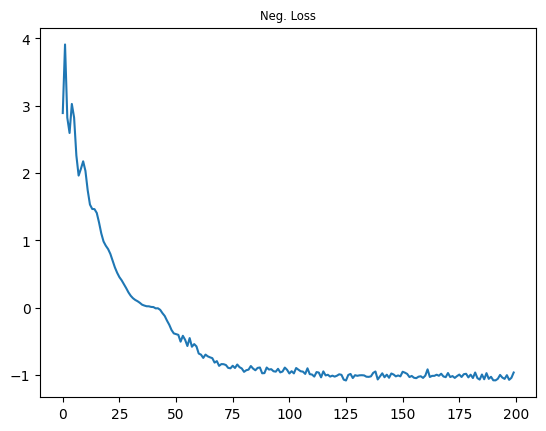

In [58]:
from matplotlib import pyplot as plt
plt.plot(loss_list)
plt.title('Neg. Loss', fontsize='small')

In [59]:
# Make predictions
model.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():

        test_mean,test_var = model.predict(t_test_x)   
        test_lower, test_upper = test_mean - 2 * test_var.sqrt(), test_mean + 2 * test_var.sqrt()
        train_mean,train_var = model.predict(t_train_x)
        train_lower, train_upper = train_mean - 2 * train_var.sqrt(), train_mean + 2 * train_var.sqrt()

In [60]:
if y_scale_option=='no-y-scale':
      arr_train_x = t_train_x.detach().numpy()
      arr_train_y = t_train_y.detach().numpy()
      arr_test_x = t_test_x.detach().numpy()
      arr_test_y = t_test_y.detach().numpy()
      arr_test_mean = test_mean.detach().numpy()
      arr_test_lower = test_lower.detach().numpy()
      arr_test_upper = test_upper.detach().numpy()

      arr_train_mean = train_mean.detach().numpy()
      arr_train_lower = train_lower.detach().numpy()
      arr_train_upper = train_upper.detach().numpy()
else:
      arr_train_x = t_train_x.detach().numpy()
      arr_test_x = t_test_x.detach().numpy()
      arr_test_y = t_test_y.detach().numpy()
    
      arr_train_y = y_scaler.inverse_transform(t_train_y)
      arr_train_mean = y_scaler.inverse_transform(train_mean)
      arr_train_lower = y_scaler.inverse_transform(train_lower)
      arr_train_upper = y_scaler.inverse_transform(train_upper)

      arr_test_mean = y_scaler.inverse_transform(test_mean)
      arr_test_lower = y_scaler.inverse_transform(test_lower)
      arr_test_upper = y_scaler.inverse_transform(test_upper)

In [42]:
df_train_comp

,true,pred,upper,lower,mode
0,93.4,94.318048,97.787656,90.848440,train
1,96.0,94.336757,97.807214,90.866299,train
2,95.9,94.338697,97.809310,90.868084,train
3,93.0,94.343469,97.812743,90.874196,train
4,94.7,94.339435,97.810208,90.868662,train
5,96.4,94.307724,97.778382,90.837066,train
6,90.3,94.321334,97.791383,90.851285,train
7,91.8,94.328685,97.798837,90.858532,train
8,96.3,94.337160,97.806449,90.867870,train
9,94.6,94.326836,97.797552,90.856121,train


             _Dimer_HMW_  _Monomer
MAE                 0.38      0.50
MAE2                0.27      0.37
MSE                 0.24      0.38
RMSE                0.49      0.62
MAPE                0.19      0.01
MAXE                1.15      1.17
EVS                 0.79      0.80
R2                  0.69      0.80
AVG_STD_PCT         0.43      0.01
MIN_STD_PCT         0.42      0.01
MAX_STD_PCT         0.44      0.01
             _Dimer_HMW_  _Monomer
MAE                 0.35      0.36
MAE2                0.26      0.22
MSE                 0.19      0.25
RMSE                0.44      0.50
MAPE                0.17      0.00
MAXE                1.27      1.70
EVS                 0.82      0.92
R2                  0.82      0.91
AVG_STD_PCT         0.38      0.01
MIN_STD_PCT         0.37      0.01
MAX_STD_PCT         0.42      0.01


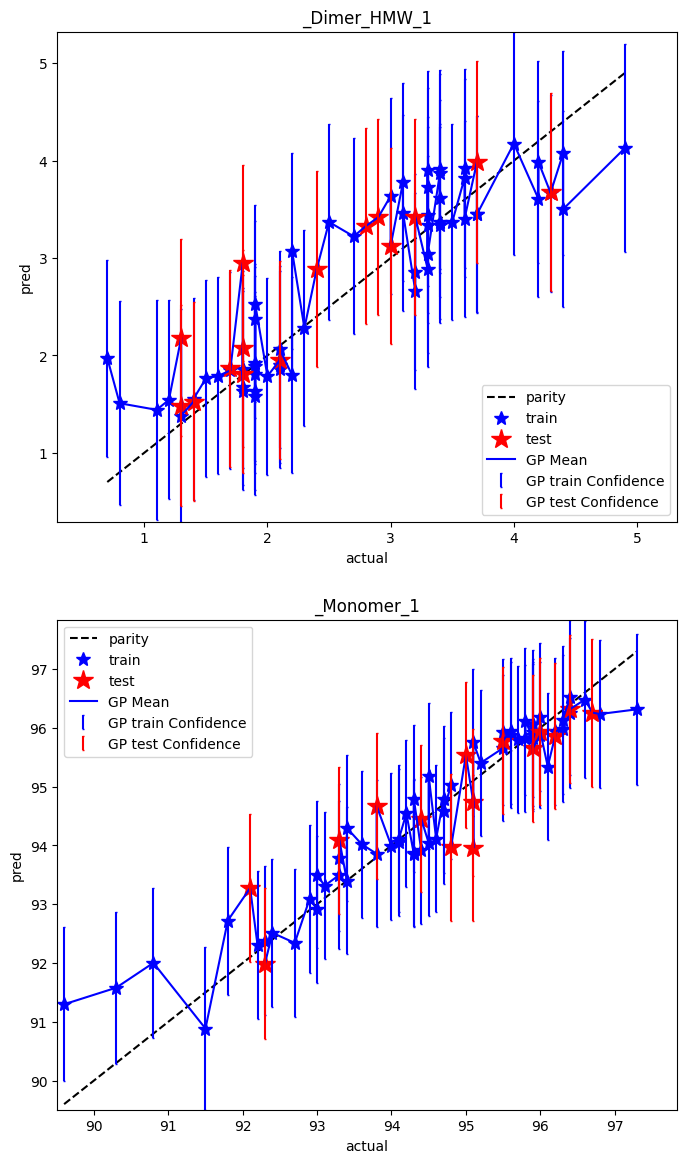

In [61]:
from sklearn import metrics


uncertainty_figure_option = 'errorbar' #shade or errorbar
is_set_axis_limit = False

plot_axis_lb = df_Y[cols_target].min(axis = 0) - 0.4*df_Y[cols_target].std(axis = 0)
plot_axis_ub = df_Y[cols_target].max(axis = 0) + 0.4* df_Y[cols_target].std(axis = 0)

num_outputs = 1#arr_train_y.shape[-1]
#num_tasks = len(np.unique(arr_train_x[..., -1]))

num_total_output = num_outputs*num_tasks
arr_train_metrics = np.zeros((11,num_total_output))
arr_test_metrics = np.zeros((11,num_total_output))

# Initialize plots
#f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(16, 48))
f, y_axes = plt.subplots(num_tasks, num_outputs, figsize=(num_outputs*8, num_tasks*7))
y_axes = y_axes.ravel()
for task_ind in range(num_tasks):
#for task_ind in range(1,2):
  for j in range(num_outputs):
    a = j + num_outputs*task_ind
    tmp_col_y = cols_target_new[a]

    
    
    r_train_y = arr_train_y[:,a]
    r_train_mean_y =arr_train_mean[:,a]
    r_train_lower_y =arr_train_lower[:,a]
    r_train_upper_y =arr_train_upper[:,a]
    r_train_std = r_train_mean_y - r_train_lower_y

    r_test_y = arr_test_y[:,a]
    r_test_mean_y =arr_test_mean[:,a]
    r_test_lower_y =arr_test_lower[:,a]
    r_test_upper_y =arr_test_upper[:,a]
    r_test_std = r_test_mean_y - r_test_lower_y
    
    train_comp = np.concatenate((r_train_y.reshape(-1,1),r_train_mean_y.reshape(-1,1)),axis = 1)
    df_train_comp = pd.DataFrame(train_comp,columns = ['true','pred'])
    df_train_comp['upper'] = r_train_upper_y
    df_train_comp['lower'] = r_train_lower_y
    df_train_comp['mode'] = 'train'
    
    test_comp = np.concatenate((r_test_y.reshape(-1,1),r_test_mean_y.reshape(-1,1)),axis = 1)
    df_test_comp = pd.DataFrame(test_comp,columns = ['true','pred'])
    df_test_comp['upper'] = r_test_upper_y
    df_test_comp['lower'] = r_test_lower_y
    df_test_comp['mode'] = 'test'
    
    df_comp = pd.concat([df_train_comp,df_test_comp])
    df_comp_sorted = df_comp.sort_values(by = ['true'],ascending=True)

    #plot a parity line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['true'], '--',c = 'black')
    
    # Plot training data as black stars
    y_axes[a].plot(df_train_comp['true'], df_train_comp['pred'], 'b*',markersize=10)

    # Plot training data as red stars
    y_axes[a].plot(df_test_comp['true'], df_test_comp['pred'], 'r*',markersize=15)
    # Predictive mean as blue line
    y_axes[a].plot(df_comp_sorted['true'], df_comp_sorted['pred'],c = 'blue')
    
    if uncertainty_figure_option == 'shade':
    # Shade in confidence
      y_axes[a].fill_between(x = df_comp_sorted['true'],y1 = df_comp_sorted['lower'], y2 = df_comp_sorted['upper'], color='b', alpha=.15)
    else:
      yerr = df_comp_sorted['pred'] - df_comp_sorted['lower']
      yerr = yerr.values.tolist()
      #y_axes[a].errorbar(x = df_comp_sorted['true'], y = df_comp_sorted['pred'], yerr = yerr, capsize=1, fmt='none', ecolor = 'black')
      yerr_train = df_train_comp['pred'] - df_train_comp['lower']
      yerr_train = yerr_train.values.tolist()
      yerr_test = df_test_comp['pred'] - df_test_comp['lower']
      yerr_test = yerr_test.values.tolist()
      y_axes[a].errorbar(x = df_train_comp['true'], y = df_train_comp['pred'], yerr = yerr_train, capsize=1, fmt='none', ecolor = 'blue')
      y_axes[a].errorbar(x = df_test_comp['true'], y = df_test_comp['pred'], yerr = yerr_test, capsize=1, fmt='none', ecolor = 'red')
    
    
    if is_set_axis_limit:
      y_axes[a].set_xlim([plot_axis_lb[j],plot_axis_ub[j]])
      y_axes[a].set_ylim([plot_axis_lb[j],plot_axis_ub[j]])
    else:
      arr_comp = df_comp[df_comp.columns.difference(['mode'])].to_numpy()
      axis_max = arr_comp.max()
      axis_min = arr_comp.min()
      y_axes[a].set_xlim([axis_min,axis_max])
      y_axes[a].set_ylim([axis_min,axis_max])

    y_axes[a].legend(['parity','train','test','GP Mean','GP train Confidence','GP test Confidence'])
    y_axes[a].set_title(tmp_col_y)
    y_axes[a].set_xlabel('actual')
    y_axes[a].set_ylabel('pred')

    y_true = r_test_y
    y_pred = r_test_mean_y
    y_train = r_train_y
    mean_train = r_train_mean_y
    

    arr_test_metrics[0,a] = np.round(metrics.mean_absolute_error(y_true, y_pred),2)
    arr_test_metrics[1,a] = np.round(metrics.median_absolute_error(y_true, y_pred),2)
    arr_test_metrics[2,a] = np.round(metrics.mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[3,a] = round(metrics.root_mean_squared_error(y_true, y_pred),2)
    arr_test_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_true, y_pred),2)
    arr_test_metrics[5,a] = round(metrics.max_error(y_true, y_pred),2)
    arr_test_metrics[6,a] = round(metrics.explained_variance_score(y_true, y_pred),2)
    arr_test_metrics[7,a] = round(metrics.r2_score(y_true, y_pred),2)
    arr_test_metrics[8,a] = round(np.mean(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[9,a] = round(np.min(r_test_std)/np.mean(y_true),2)
    arr_test_metrics[10,a] = round(np.max(r_test_std)/np.mean(y_true),2)

    arr_train_metrics[0,a] = round(metrics.mean_absolute_error(y_train, mean_train),2)
    arr_train_metrics[1,a] = round(metrics.median_absolute_error(y_train, mean_train),2)
    arr_train_metrics[2,a] = round(metrics.mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[3,a] = round(metrics.root_mean_squared_error(y_train, mean_train),2)
    arr_train_metrics[4,a] = round(metrics.mean_absolute_percentage_error(y_train, mean_train),2)
    arr_train_metrics[5,a] = round(metrics.max_error(y_train, mean_train),2)
    arr_train_metrics[6,a] = round(metrics.explained_variance_score(y_train, mean_train),2)
    arr_train_metrics[7,a] = round(metrics.r2_score(y_train, mean_train),2)
    arr_train_metrics[8,a] = round(np.mean(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[9,a] = round(np.min(r_train_std)/np.mean(y_train),2)
    arr_train_metrics[10,a] = round(np.max(r_train_std)/np.mean(y_train),2)
    #arr_train_metrics[11,i] = my_gpr.kernel_.get_params()['k1__constant_value']
    #arr_train_metrics[12,i] = my_gpr.kernel_.get_params()['k2__length_scale']

if uncertainty_figure_option == 'shade' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade.jpg')
elif uncertainty_figure_option == 'shade' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-shade-zoomin.jpg')
elif uncertainty_figure_option == 'errorbar' and is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar.jpg')
elif uncertainty_figure_option == 'errorbar' and ~is_set_axis_limit:
  plt.savefig(figPath+'/true-pred-errorbar-zoomin.jpg')

df_test_metrics = pd.DataFrame(arr_test_metrics,columns = cols_target, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD_PCT','MIN_STD_PCT','MAX_STD_PCT'])
print(df_test_metrics)

df_train_metrics = pd.DataFrame(arr_train_metrics,columns = cols_target, 
                               index = ['MAE','MAE2','MSE','RMSE','MAPE','MAXE','EVS','R2','AVG_STD_PCT','MIN_STD_PCT','MAX_STD_PCT'])
print(df_train_metrics)

df_train_metrics.to_csv(figPath+'/df_train_metrics.csv')
df_test_metrics.to_csv(figPath+'/df_test_metrics.csv')

In [44]:
a

1

In [26]:
# Make predictions
model.eval()
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    mean, var = model.predict(t_test_x)
    lower = mean - 2 * var.sqrt()
    upper = mean + 2 * var.sqrt()

/Users/chenya68/anaconda3/envs/local-gp-mac-no-tf/lib/python3.10/site-packages/linear_operator/utils/interpolation.py:71: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403210267/work/torch/csrc/utils/tensor_new.cpp:620.)
  summing_matrix = cls(summing_matrix_indices, summing_matrix_values, size)


In [28]:
var.shape

torch.Size([15, 2])

In [ ]:



from matplotlib import pyplot as plt
# Plot results
fig, axs = plt.subplots(1, num_tasks, figsize=(4 * num_tasks, 3))
for task, ax in enumerate(axs):
    ax.plot(t_train_x.squeeze(-1).detach().numpy(), t_train_y[:, task].detach().numpy(), 'k*')
    ax.plot(t_test_x.squeeze(-1).numpy(), mean[:, task].numpy(), 'b')
    ax.fill_between(t_test_x.squeeze(-1).numpy(), lower[:, task].numpy(), upper[:, task].numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(f'Task {task + 1}')
fig.tight_layout()